In [15]:
import numpy as np
import tensorflow as tf
from keras.datasets import imdb
from keras import preprocessing
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Flatten, Dense, Embedding, GlobalAveragePooling1D

## Data Preparation

In [16]:
# Load IMDB data
max_features = 10000
maxlen = 150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
x_val = x_test[:10000]
y_val = y_test[:10000]

# load GloVe
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# prepare embedding matrix
word_index = imdb.get_word_index()
reverse_word_index = dict((value, key) for (key, value) in word_index.items())
embedding_dim = 100
embedding_matrix = np.zeros((max_features, embedding_dim))
for i in range(1, max_features):
    word = reverse_word_index.get(i)
    if word:
        vec = embedding_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec


## Compare Performances


Training with 100 samples...

Training with 500 samples...

Training with 1000 samples...

Training with 2000 samples...

Training with 5000 samples...

Training with 10000 samples...


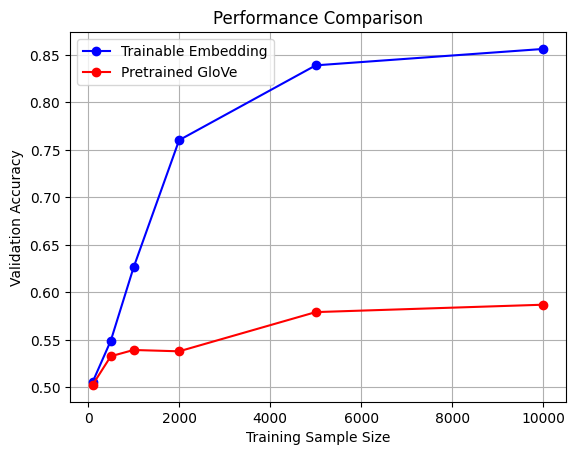

In [17]:
# build trainable embedding model
def build_trainable_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=8, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

# build fixed GloVe model
def build_glove_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen,
                        weights=[embedding_matrix], trainable=False))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

# try different training sizes
sample_sizes = [100, 500, 1000, 2000, 5000, 10000]
results_embed = []
results_glove = []

for size in sample_sizes:
    print(f"\nTraining with {size} samples...")

    x_small = x_train[:size]
    y_small = y_train[:size]

    # train trainable embedding model
    model_embed = build_trainable_model()
    hist_embed = model_embed.fit(x_small, y_small,
                                 epochs=10, batch_size=32,
                                 validation_data=(x_val, y_val),
                                 verbose=0)
    val_acc_embed = hist_embed.history['val_acc'][-1]

    # train GloVe embedding model
    model_glove = build_glove_model()
    hist_glove = model_glove.fit(x_small, y_small,
                                 epochs=10, batch_size=32,
                                 validation_data=(x_val, y_val),
                                 verbose=0)
    val_acc_glove = hist_glove.history['val_acc'][-1]

    results_embed.append(val_acc_embed)
    results_glove.append(val_acc_glove)

plt.plot(sample_sizes, results_embed, 'bo-', label='Trainable Embedding')
plt.plot(sample_sizes, results_glove, 'ro-', label='Pretrained GloVe')
plt.xlabel('Training Sample Size')
plt.ylabel('Validation Accuracy')
plt.title('Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
results_embed

[0.5054000020027161,
 0.5490999817848206,
 0.6262000203132629,
 0.7602999806404114,
 0.8391000032424927,
 0.8564000129699707]

In [19]:
results_glove

[0.5024999976158142,
 0.5327000021934509,
 0.5393000245094299,
 0.5378999710083008,
 0.579200029373169,
 0.5870000123977661]